# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [4]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = 1e-4*(np.rot90(Bx))
B[1, :, :] = 1e-4*(np.rot90(By))
B[2, :, :] = 1e-4*(np.rot90(Bz))
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
dataset.add_hanning_filter(1)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
# dataset.plot_target()

In [5]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 1


In [6]:
print(len(dataset.target.size()))

3


# 3. Current reconstruction

## 3.1. Transform B → J

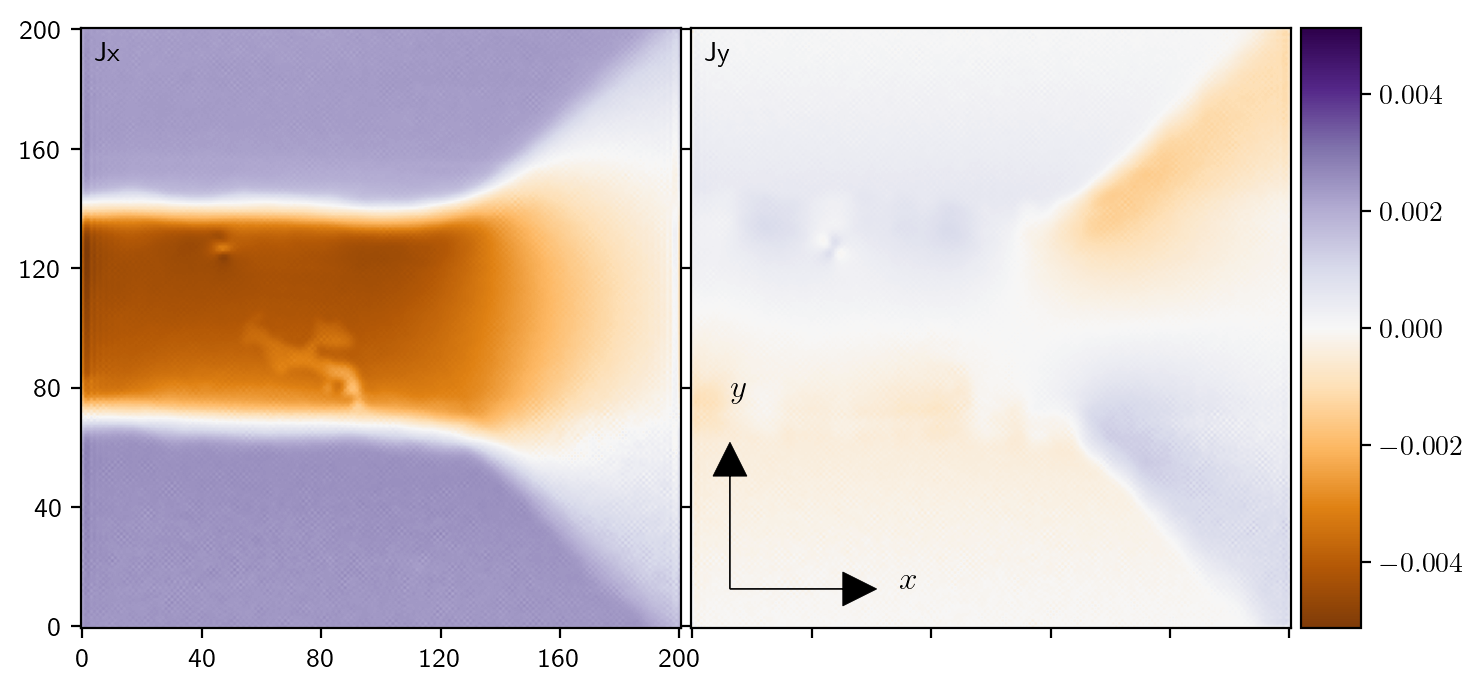

In [7]:
dataset.set_transformer(Bxyz2Jxy)
dataset.transform_data()


plot_n_components(
    dataset.transformed_target, 
    symmetric=True, 
    labels=["Jx", "Jy"], 
    cmap="PuOr")


torch.Size([2, 201, 201])


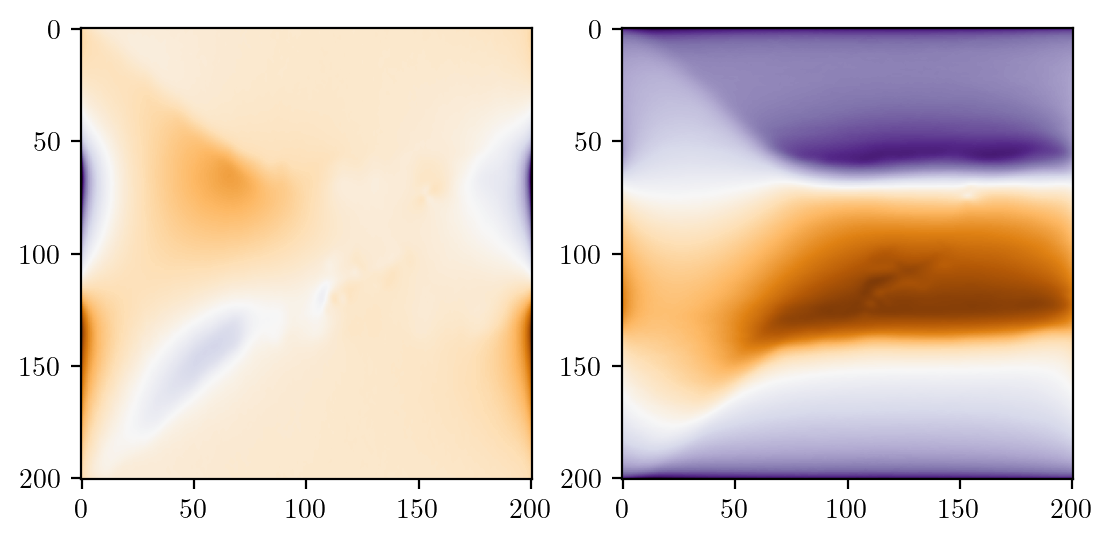

In [37]:
from magrec.transformation.Fourier import FourierTransform2d
from magrec.transformation.Kernel import CurrentLayerFourierKernel2d

def Bsensor2Jxy(image: torch.Tensor, s_theta: float, s_phi: float, dx: float, dy: float, height: float, thickness: float):
    
    ft = FourierTransform2d(grid_shape=image.shape, dx=dx, dy=dy, real_signal=False)
    s_theta = np.deg2rad(dataset.sensor_theta)
    s_phi = np.deg2rad(dataset.sensor_phi)

    sensor_dir = torch.tensor([ \
        np.cos(s_phi)*np.sin(s_theta), \
        np.sin(s_phi)*np.sin(s_theta), \
        np.cos(s_theta)], dtype=torch.complex64)

    b_to_j_matrix = CurrentLayerFourierKernel2d.define_kernel_matrix(
        ft.kx_vector, 
        ft.ky_vector, 
        height=height, 
        layer_thickness=thickness
    )
    # Project the kernel matrix onto the sensor direction
    b_to_j_matrix = torch.einsum("ijkl,i->jkl", b_to_j_matrix, sensor_dir)
    b_to_j_matrix[b_to_j_matrix != b_to_j_matrix] = 0


    B = image
    b = ft.forward(B, dim=(-2, -1))
    j = b * b_to_j_matrix
    J = ft.backward(j, dim=(-2, -1))
    return J


Image = torch.Tensor(Bsensor.copy())
Jtest = Bsensor2Jxy(Image, s_theta=54.7, s_phi=45, dx=0.4, dy=0.4, height=0.1, thickness=0.1)

print(Jtest.shape)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(Jtest[0,::].real, cmap="PuOr")

plt.subplot(1,2,2)
plt.imshow(Jtest[1,::].real, cmap="PuOr")



## 3.2 test that the Jxy to Bsensor transform works

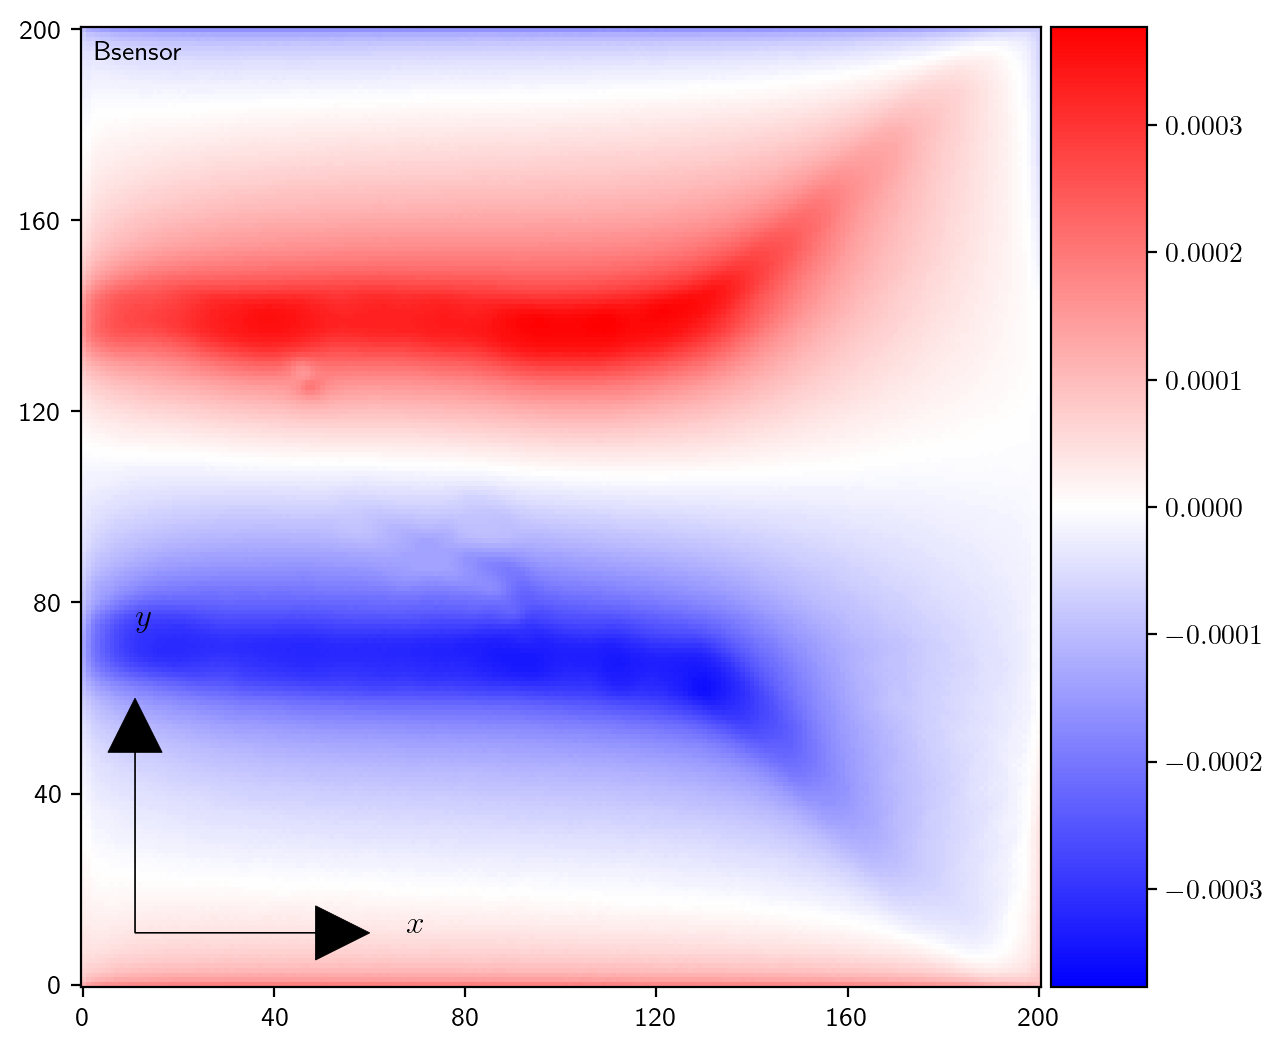

In [8]:
from magrec.transformation.Jxy2Bsensor import Jxy2Bsensor
brecon = Jxy2Bsensor(dataset)

B_sensor_recon = brecon.transform(dataset.transformed_target)

plot_n_components(
    B_sensor_recon, 
    symmetric=True, 
    labels=["Bsensor"], 
    cmap="bwr")

## Now we will try to reconstruct the current density using a neural network.

In [30]:
from magrec.method.CNN import CNN
from magrec.models.Jxy import Jxy

sensor_theta = 0
sensor_phi = 0 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset2 = Data()
dataset2.load_data(
       B[2,::]*1e3, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset2.remove_DC_background()
dataset2.add_hanning_filter(1)
dataset2.crop_data((2,198,1,198))
# dataset2.pad_reflective2d()
dataset2.pad_data_to_power_of_two()
# dataset2.plot_target()




[30, 226, 29, 226]


In [31]:
# import magrec.image_processing.Masks as Masks
# weight1 = Masks.mask_hor_dir(dataset2.target, 1.5,  plot=True)
# weight2 = Masks.mask_vert_dir(dataset2.target, 0.01,  plot=True)

# weight = weight1 * weight2

In [32]:
Model = Jxy(dataset2, "MSE")
FittingMethod = CNN(Model, dataset2)
FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 1


In [33]:
FittingMethod.fit(n_epochs=100)

C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  2.11e+10
epoch    11 | loss on last mini-batch:  3.04e+09
epoch    21 | loss on last mini-batch:  1.99e+09
epoch    31 | loss on last mini-batch:  1.60e+09
epoch    41 | loss on last mini-batch:  1.26e+09
epoch    51 | loss on last mini-batch:  1.10e+09
epoch    61 | loss on last mini-batch:  8.26e+08
epoch    71 | loss on last mini-batch:  6.15e+08
epoch    81 | loss on last mini-batch:  7.74e+08
epoch    91 | loss on last mini-batch:  4.39e+08


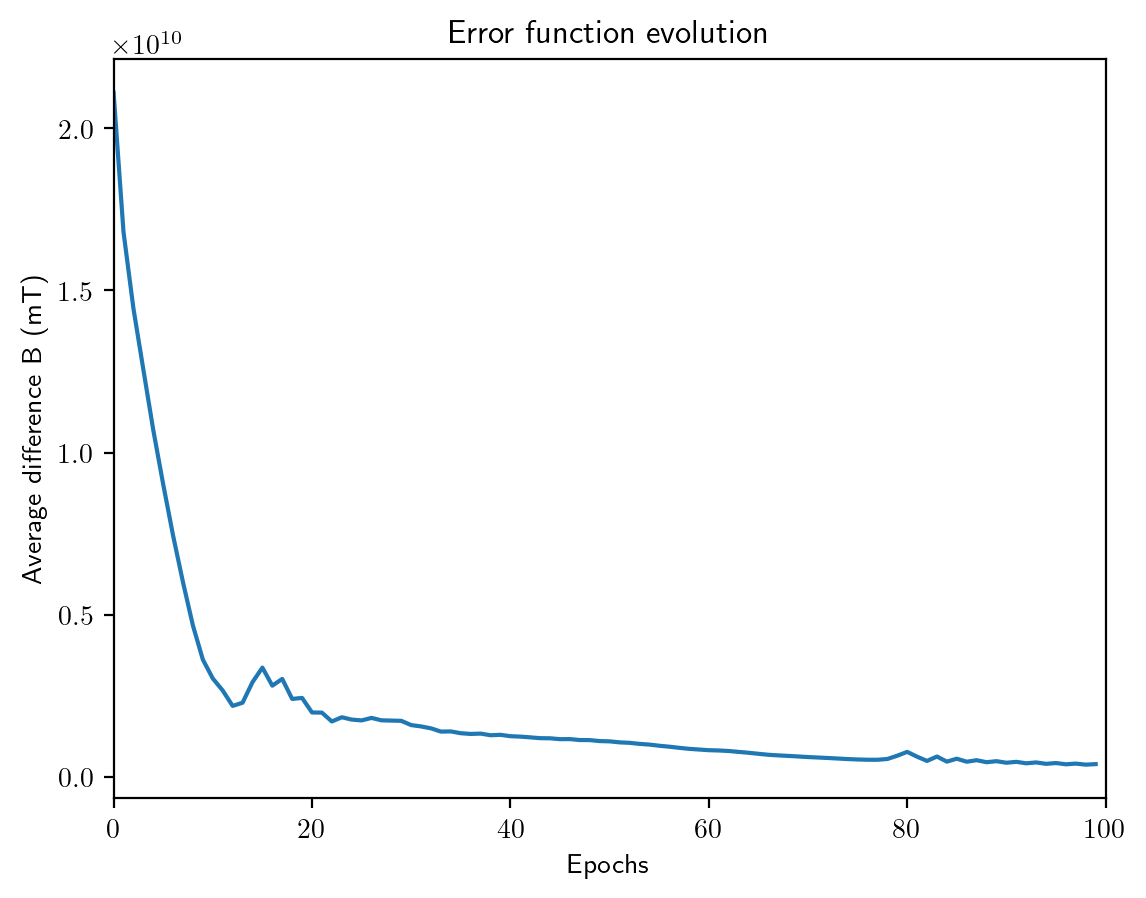

In [34]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


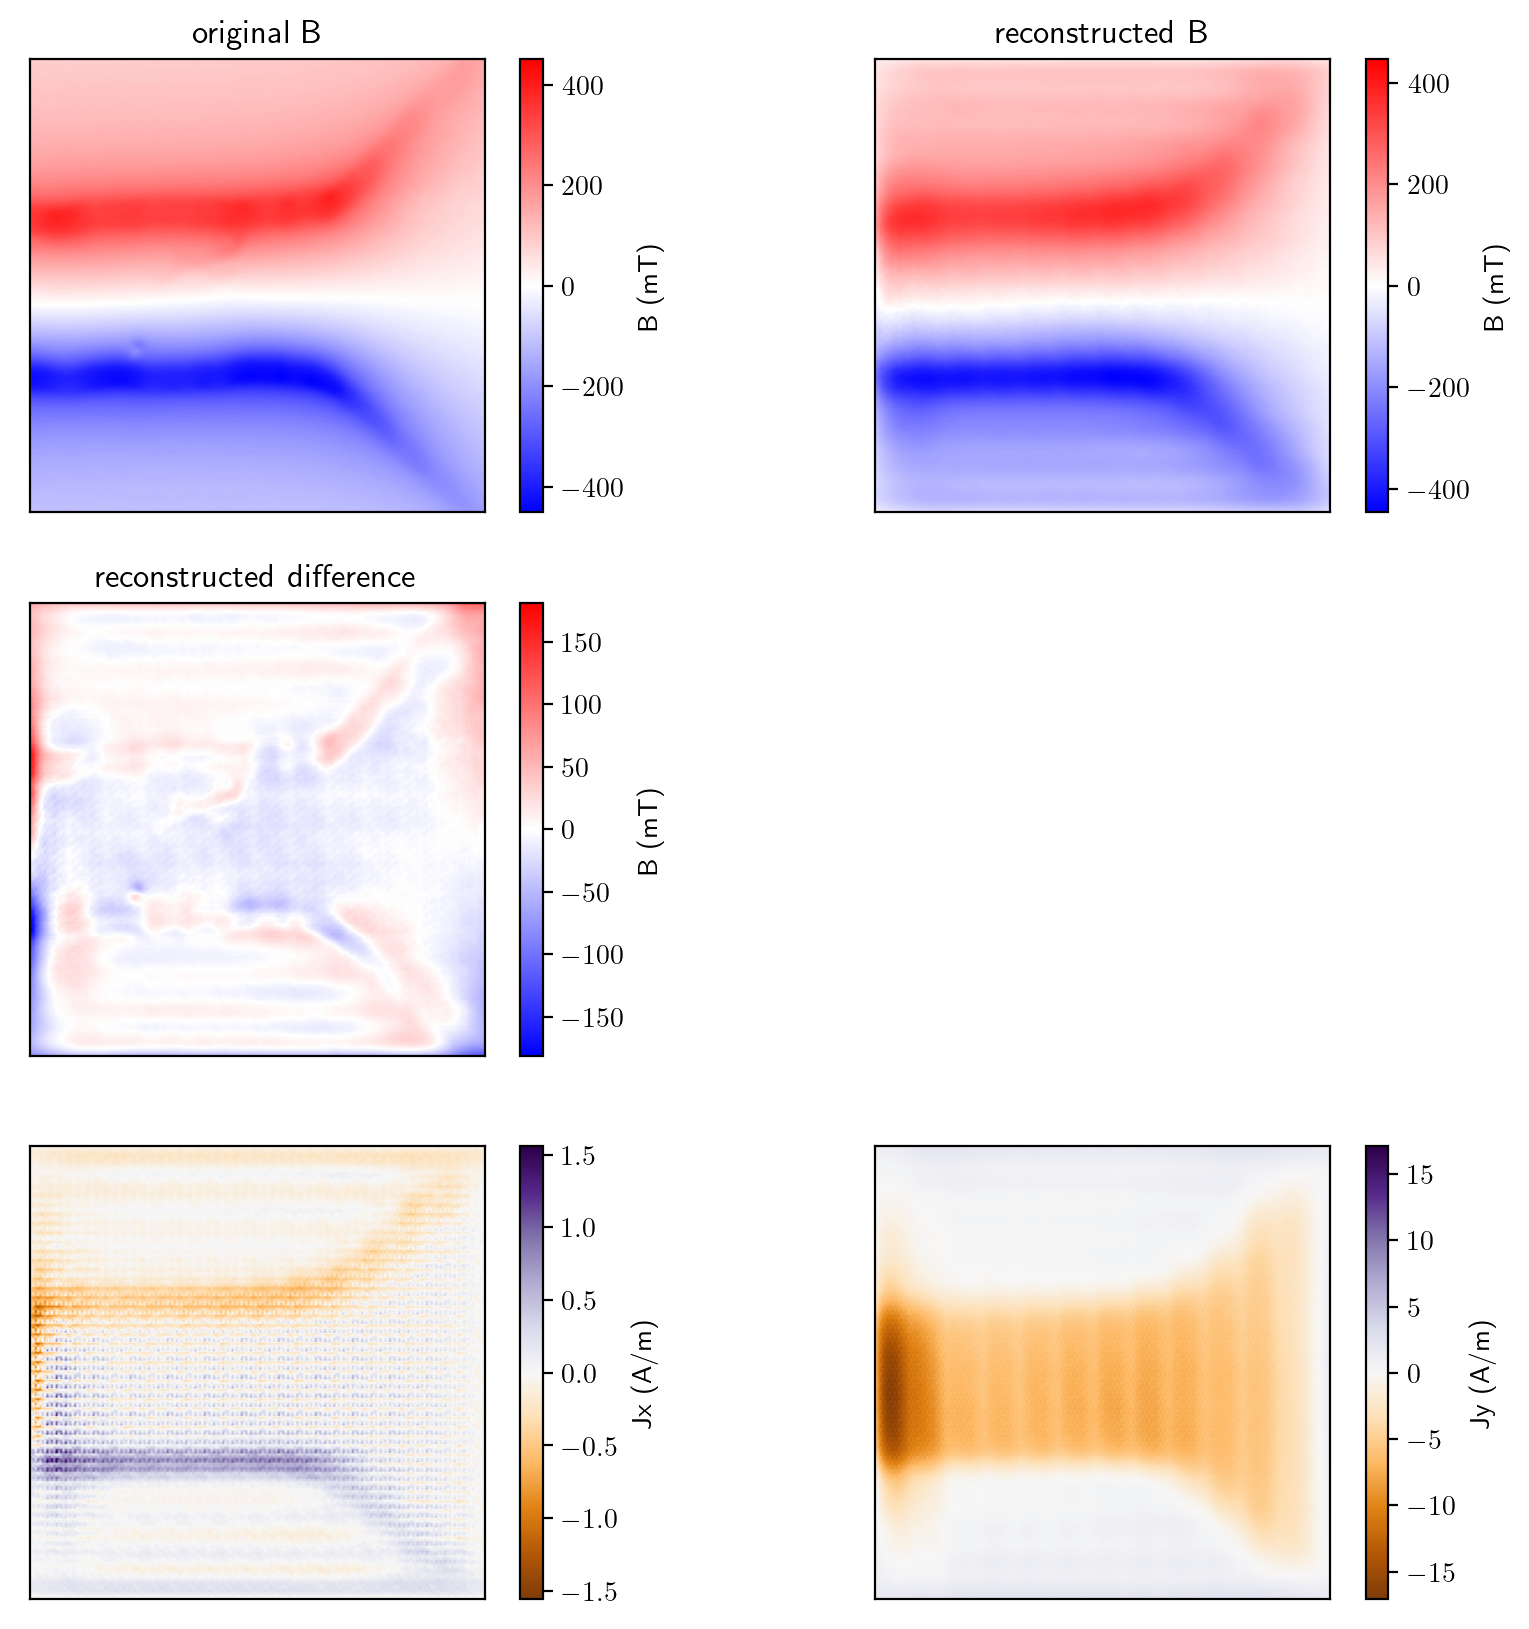

In [35]:
FittingMethod.plot_results()